In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
import joblib
import warnings
warnings.filterwarnings("ignore")


In [5]:
df = pd.read_csv("/content/construction_estimates.csv")  # Change path if needed
df.columns = df.columns.str.strip()

In [ ]:
print("Initial Data Shape:", df.shape)
df.head()

Initial Data Shape: (1000, 6)


,Material_Cost,Labor_Cost,Profit_Rate,Discount_or_Markup,Policy_Reason,Total_Estimate
0,43985,12836,10,1095,Market conditions require competitive pricing ...,63598.10
1,45504,17873,15,-6426,Market conditions require competitive pricing ...,66457.55
2,33656,8401,25,9862,"The client is a repeat customer, deserving a l...",62433.25
3,36509,8523,20,8096,"The client is a repeat customer, deserving a l...",62134.40
4,37372,14123,30,-9598,Strategic importance of this client justifies ...,57345.50


In [6]:
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 Material_Cost         0
Labor_Cost            0
Profit_Rate           0
Discount_or_Markup    0
Policy_Reason         0
Total_Estimate        0
dtype: int64


In [7]:
df.dropna(inplace=True)
print("Data Shape after dropping NA:", df.shape)

Data Shape after dropping NA: (1000, 6)


In [8]:
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].str.strip()


In [9]:
numcols = ['Material_Cost', 'Labor_Cost', 'Profit_Rate', 'Discount_or_Markup', 'Total_Estimate']
for c in numcols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df.dropna(subset=numcols, inplace=True)

In [10]:
df['Base_Cost'] = df['Material_Cost'] + df['Labor_Cost']
df['Profit_Amount'] = df['Base_Cost'] * (df['Profit_Rate'] / 100.0)
df['Discount_or_Markup_pct'] = df['Discount_or_Markup']  # keep as is; adjust if needed
df['Final_Cost_Estimation'] = df['Base_Cost'] + df['Profit_Amount'] + df['Discount_or_Markup_pct']


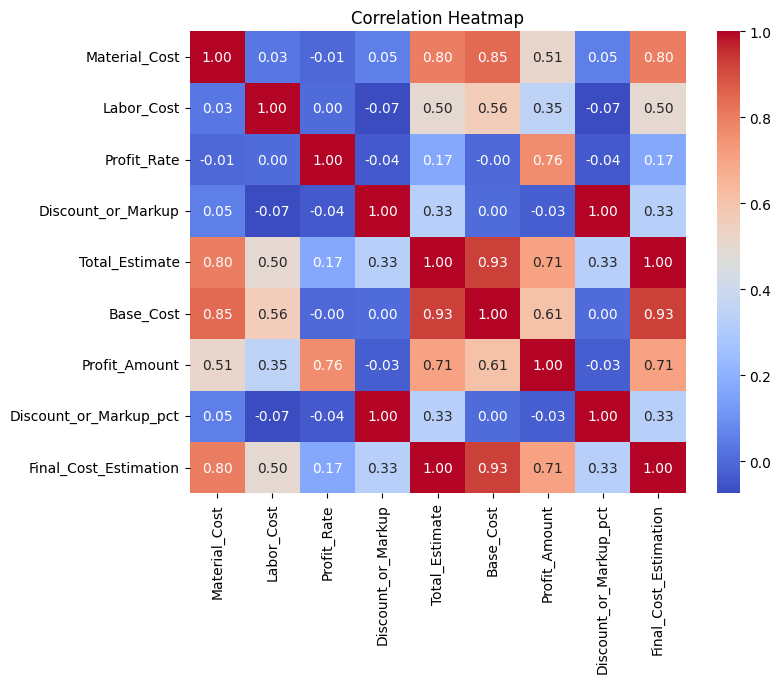

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

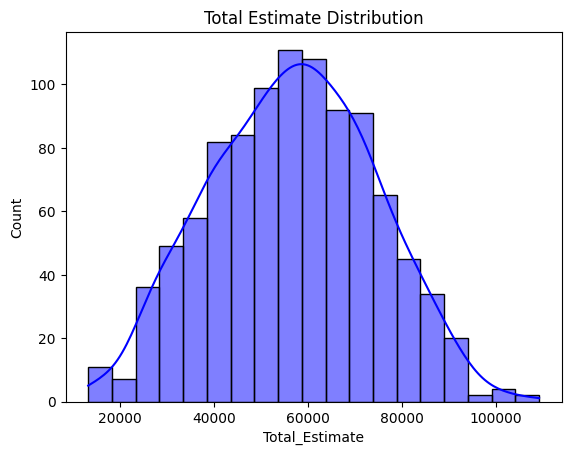

In [12]:
sns.histplot(df['Total_Estimate'], kde=True, color='blue')
plt.title("Total Estimate Distribution")
plt.show()

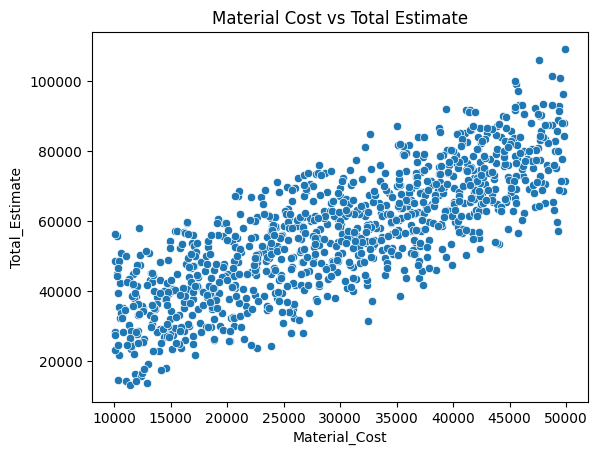

In [13]:
sns.scatterplot(x='Material_Cost', y='Total_Estimate', data=df)
plt.title("Material Cost vs Total Estimate")
plt.show()

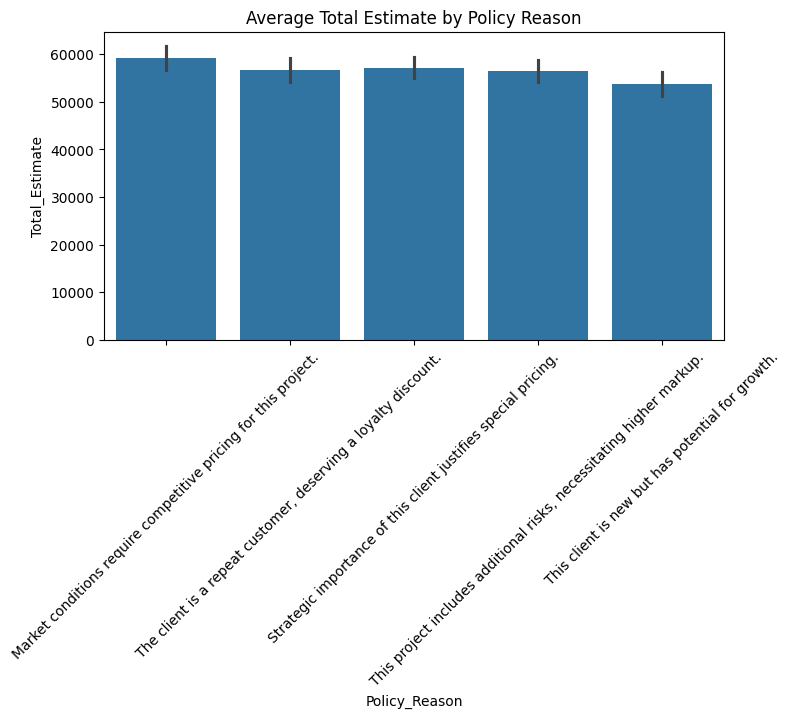

In [14]:
plt.figure(figsize=(8,4))
sns.barplot(x='Policy_Reason', y='Total_Estimate', data=df, estimator=np.mean)
plt.xticks(rotation=45)
plt.title("Average Total Estimate by Policy Reason")
plt.show()


In [15]:
X = df.drop('Total_Estimate', axis=1)
y = df['Total_Estimate']

In [16]:
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])


In [19]:
pipe_lr = Pipeline([
    ('pre', preprocessor),
    ('lr', LinearRegression())
])

In [20]:
pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])

In [21]:
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Material_Cost',
                                                   'Labor_Cost', 'Profit_Rate',
                                                   'Discount_or_Markup',
                                                   'Base_Cost', 'Profit_Amount',
                                                   'Discount_or_Markup_pct',
                                                   'Final_Cost_Estimation']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Policy_Reason'])])),
                ('rf', RandomForestRegressor(random_state=42))])

In [22]:
y_pred_lr = pipe_lr.predict(X_test)
y_pred_rf = pipe_rf.predict(X_test)


In [23]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n----- {model_name} -----")
    print("MAE:", round(mean_absolute_error(y_true, y_pred), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_true, y_pred)), 2))
    print("R2 Score:", round(r2_score(y_true, y_pred), 3))


In [24]:
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")


----- Linear Regression -----
MAE: 0.0
RMSE: 0.0
R2 Score: 1.0

----- Random Forest -----
MAE: 115.93
RMSE: 527.9
R2 Score: 0.999


In [25]:
ohe_features = list(num_cols) + list(pipe_rf.named_steps['pre'].named_transformers_['cat'].get_feature_names_out(cat_cols))
importances = pipe_rf.named_steps['rf'].feature_importances_
fi = pd.Series(importances, index=ohe_features).sort_values(ascending=False).head(10)

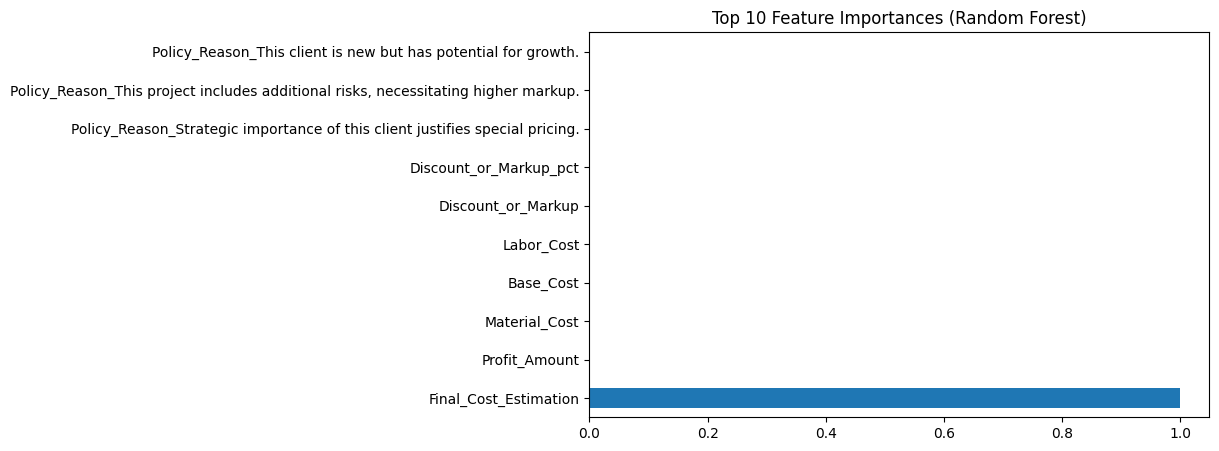

In [26]:
plt.figure(figsize=(8,5))
fi.plot.barh()
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

In [27]:
def simulate_material_increase(sample_row, pct_increase):
    row = sample_row.copy()
    row['Material_Cost'] *= (1 + pct_increase / 100)
    return pipe_rf.predict(pd.DataFrame([row]))[0]

In [28]:
sample_project = X_test.iloc[0]
print("\nOriginal Prediction:", pipe_rf.predict(pd.DataFrame([sample_project]))[0])
print("Prediction with +10% Material Cost:", simulate_material_increase(sample_project, 10))


Original Prediction: 53451.3945
Prediction with +10% Material Cost: 53451.3945


In [29]:
df.to_csv("cleaned_for_powerbi.csv", index=False)
joblib.dump(pipe_rf, "construction_rf.pkl")


['construction_rf.pkl']

In [30]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [31]:
print("\n✅ Cleaned data saved as 'cleaned_for_powerbi.csv'")
print("✅ Model saved as 'construction_rf.pkl'")


✅ Cleaned data saved as 'cleaned_for_powerbi.csv'
✅ Model saved as 'construction_rf.pkl'
